In [1]:
import pandas as pd
# 一元拟合
from sklearn import linear_model
import matplotlib.pyplot as plt
import scipy.stats as stats

进行拟合就是用实验过程中COD去除量减去反硝化的COD去除量，然后找到厌氧COD的反应速率。

In [2]:
# 加载VSS文件
VSS_data= pd.read_csv('../VSS.csv', header=0, index_col=[0, 1, 2])

In [3]:
anaerobic_rate={
    "Denitrification_NO2":dict(),
    "Denitrification_NO3":dict()
}

In [4]:
VSS_data.at[("Nitrogen_Substance","Denitrification_NO2","De_nitrite1"),"VSS"]

0.489

In [5]:
def calculate_from_Denitrification_NO2(target):
    '''

    :param target: 数据文件
    :return:
    '''
    NO2 = pd.read_csv(f'../Nitrogen_Substance/Denitrification_NO2/data/{target}.csv',
                            header=0, index_col=None,
                            usecols=["Mins","NO2--N","COD"],  
                            encoding='utf-8')
    
    # 计算每两个取样点之间的时间段内因去除亚硝酸盐而消耗COD的理论量，
    # 获得实验的COD数据，去除初始数据点。(容易出现误差)。
    Observed_COD=list(NO2.loc[1:,"COD"])
    #实验过程中的NO2--N变化信息
    Observed_nitrite=list(NO2.loc[1:,"NO2--N"])
    print(f"实验过程中的COD/TN为{(Observed_COD[0]-Observed_COD[-1])/(Observed_nitrite[0]-Observed_nitrite[-1])}")
    #参与计算的第一个COD数据点。
    Denitrification_COD_begin=Observed_COD[0]
    # 反硝化去除亚硝酸盐的COD理论消耗曲线
    DE_COD_profile=[Denitrification_COD_begin,]
   
    for i in range(2,NO2.shape[0]):
        
        #通过循环计算，由于亚硝酸盐反硝化过程去除亚硝酸盐所消耗的COD的变化曲线
        Denitrification_COD_end=Denitrification_COD_begin-1.71*(NO2.at[i-1,"NO2--N"]-NO2.at[i,"NO2--N"])
        DE_COD_profile.append(Denitrification_COD_end)
        Denitrification_COD_begin=Denitrification_COD_end
    print(f"亚硝酸盐去除COD：{DE_COD_profile}")

    # 计算厌氧消化的COD消耗曲线
    Anaerobic_digestion_COD_begin=Observed_COD[0]
    Anaerobic_digestion_COD_profile=[Anaerobic_digestion_COD_begin,]
    
    
    for index in range(1,len(Observed_COD)):
        
        ## 两个数据点之前满足的关系式有：Δobserved_COD-ΔDE_COD_profile=ΔAnaerobic_digestion_COD

        Anaerobic_digestion_COD_end=Anaerobic_digestion_COD_begin-((Observed_COD[index-1]-Observed_COD[index])-(DE_COD_profile[index-1]-DE_COD_profile[index]))
        Anaerobic_digestion_COD_profile.append(Anaerobic_digestion_COD_end)
        Anaerobic_digestion_COD_begin=Anaerobic_digestion_COD_end

    print(f"厌氧消化去除COD{Anaerobic_digestion_COD_profile}")

    #进行线性拟合
    reg = linear_model.LinearRegression()
    #因为从去除掉了，第一个实验数据。所以这里要从1开始
    reg.fit(NO2.loc[1:,"Mins"].values.reshape(-1,1),Anaerobic_digestion_COD_profile)
    # 计算R2
    # 进行T检验
    print(f"pearsonr为",stats.pearsonr(NO2.loc[1:,"Mins"],Anaerobic_digestion_COD_profile))
    #得出出预测值
    y_predict=reg.predict(NO2.loc[1:,"Mins"].values.reshape(-1,1))
    # 画出图像
    plt.scatter(NO2.loc[1:,"Mins"],Anaerobic_digestion_COD_profile,color="r",label="COD anaerobic digestion")
    plt.scatter(NO2.loc[1:,"Mins"],DE_COD_profile,label="nitrite denitrification")
    plt.scatter(NO2.loc[1:,"Mins"],Observed_COD,label="total COD consumption")
    plt.plot(NO2.loc[1:,"Mins"],y_predict,color="r")
    plt.legend()
    #拟合的参数
    print(reg.coef_,reg.intercept_)
    VSS=VSS_data.at[("Nitrogen_Substance","Denitrification_NO2",f"{target}"),"VSS"]
    anaerobic_rate["Denitrification_NO2"][target]=reg.coef_[0]/VSS
    print(f'单位VSS的厌氧COD去除速率:{-anaerobic_rate["Denitrification_NO2"][target]:0.3f} mgCOD/gVSS/min')


实验过程中的COD/TN为6.67313177410154
亚硝酸盐去除COD：[125.402, 122.1701, 120.35237000000001, 118.56200000000001, 117.77540000000002, 116.47067000000001, 116.05514000000001, 115.10609000000001, 114.26135000000001, 113.9621, 113.58248, 113.41148]
厌氧消化去除COD[125.402, 120.95589999999999, 116.06563, 115.27099999999999, 112.88259999999998, 108.63632999999999, 108.17786, 103.94591, 102.35364999999999, 100.0309, 96.22652000000001, 90.60052]
pearsonr为 (-0.967454292724715, 2.722793299257082e-07)
[-0.10379057] 132.99473187521207
单位VSS的厌氧COD去除速率:0.212 mgCOD/gVSS/min


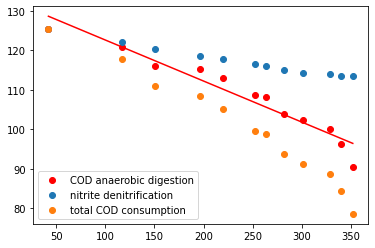

In [6]:
calculate_from_Denitrification_NO2(target="De_nitrite1")

实验过程中的COD/TN为8.815028645993246
亚硝酸盐去除COD：[126.6530966, 122.9030666, 121.3213166, 119.8814966, 118.33736660000001, 117.3489866, 116.7436466, 116.42216660000001, 116.03399660000001, 115.6971266, 115.5192866, 115.5141566]
厌氧消化去除COD[126.6530966, 111.5044982, 110.45238679999999, 105.04909042, 106.33475739, 98.92924278, 98.72227038999999, 95.12988164999999, 92.03495462, 89.75027102, 83.40499643999999, 80.37093999999999]
pearsonr为 (-0.9792866348311167, 2.9003580388307797e-08)
[-0.13325244] 131.46440347819944
单位VSS的厌氧COD去除速率:0.278 mgCOD/gVSS/min


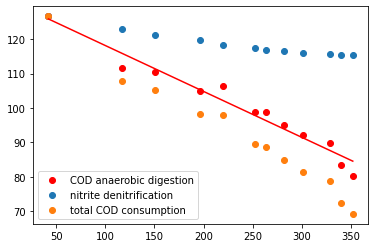

In [7]:
calculate_from_Denitrification_NO2(target="De_nitrite2")

实验过程中的COD/TN为7.807921082645824
亚硝酸盐去除COD：[128.9361289, 126.0735889, 122.8878589, 121.0376389, 120.22196890000001, 119.0591689, 118.1186689, 117.5116189, 117.12002890000001, 117.1268689, 117.12173890000001]
厌氧消化去除COD[128.9361289, 129.50942500000002, 111.15656910000001, 108.39137780000001, 107.13934358, 106.13597723000001, 105.26723601, 100.48348566000001, 96.29658769000001, 94.29589003000001, 86.80559214]
pearsonr为 (-0.9699890170068085, 7.87786086778523e-07)
[-0.13343647] 134.48363086113602
单位VSS的厌氧COD去除速率:0.268 mgCOD/gVSS/min


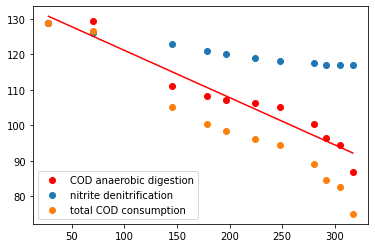

In [8]:
calculate_from_Denitrification_NO2(target="De_nitrite3")

In [9]:
def calculate_from_Denitrification_NO3(target):

    NO3 = pd.read_csv(f'../Nitrogen_Substance/Denitrification_NO3/data/{target}.csv',
                            header=0, index_col=None,
                            usecols=["Mins","NO3--N","COD"],  # 这里要使用两列数据
                            encoding='utf-8')

    # 获得实验的COD数据，去除初始数据点。(容易出现误差)。
    Observed_COD=list(NO3.loc[1:,"COD"])
        #实验过程中的硝化掉的NO3--N
    Observed_nitrate=list(NO3.loc[1:,"NO3--N"])
    print(f"实验过程中的COD/TN为{(Observed_COD[0]-Observed_COD[-1])/(Observed_nitrate[0]-Observed_nitrate[-1])}")
    #参与计算的第一个COD数据点。
    Denitrification_COD_begin=Observed_COD[0]
    # 反硝化去除硝酸盐的COD理论消耗曲线
    DE_COD_profile=[Denitrification_COD_begin,]

    for i in range(2,NO3.shape[0]):
        #通过循环计算，由于硝酸盐反硝化过程去除硝酸盐所消耗的COD的变化曲线

        Denitrification_COD_end=Denitrification_COD_begin-2.86*(NO3.at[i-1,"NO3--N"]-NO3.at[i,"NO3--N"])
        DE_COD_profile.append(Denitrification_COD_end)
        Denitrification_COD_begin=Denitrification_COD_end
    print(f"硝酸盐去除COD：{DE_COD_profile}")

    # 计算厌氧消化的COD消耗曲线
    Anaerobic_digestion_COD_begin=Observed_COD[0]
    Anaerobic_digestion_COD_profile=[Anaerobic_digestion_COD_begin,]

    for index in range(1,len(Observed_COD)):

        # 两个数据点之前满足的关系式有：Δobserved_COD-ΔDE_COD_profile=ΔAnaerobic_digestion_COD


        Anaerobic_digestion_COD_end=Anaerobic_digestion_COD_begin-((Observed_COD[index-1]-Observed_COD[index])-(DE_COD_profile[index-1]-DE_COD_profile[index]))
        Anaerobic_digestion_COD_profile.append(Anaerobic_digestion_COD_end)
        Anaerobic_digestion_COD_begin=Anaerobic_digestion_COD_end

    print(f"厌氧消化去除COD{Anaerobic_digestion_COD_profile}")

    #进行线性拟合
    reg = linear_model.LinearRegression()
    #因为从去除掉了，第一个实验数据。所以这里要从1开始
    reg.fit(NO3.loc[1:,"Mins"].values.reshape(-1,1),Anaerobic_digestion_COD_profile)

    # 进行T检验
    print(f"pearsonr为",stats.pearsonr(NO3.loc[1:,"Mins"],Anaerobic_digestion_COD_profile))
    #得出出预测值
    y_predict=reg.predict(NO3.loc[1:,"Mins"].values.reshape(-1,1))
    # 画出图像
    plt.scatter(NO3.loc[1:,"Mins"],Anaerobic_digestion_COD_profile,color="r",label="COD anaerobic digestion")
    plt.scatter(NO3.loc[1:,"Mins"],DE_COD_profile,label="nitrate denitrification")
    plt.scatter(NO3.loc[1:,"Mins"],Observed_COD,label="total COD consumption")
    plt.plot(NO3.loc[1:,"Mins"],y_predict,color="r")
    plt.legend()
    #拟合的参数
    print(reg.coef_,reg.intercept_)
    VSS=VSS_data.at[("Nitrogen_Substance","Denitrification_NO3",f"{target}"),"VSS"]
    anaerobic_rate["Denitrification_NO3"][target]=reg.coef_[0]/VSS
    print(f'单位VSS的厌氧COD去除速率:{-anaerobic_rate["Denitrification_NO3"][target]:0.3f} mgCOD/gVSS/min')


实验过程中的COD/TN为11.665967064901515
硝酸盐去除COD：[117.539, 113.22612, 109.75121999999999, 107.15433999999999, 104.96358, 103.58506, 102.10358, 101.55731999999999, 101.0225, 100.65928, 99.78125999999999, 99.82415999999999]
厌氧消化去除COD[117.539, 105.60588, 113.04378000000001, 109.70866000000001, 100.85942, 94.08994000000001, 91.87942000000001, 77.55768, 69.09549999999999, 73.42172, 66.39774, 62.994839999999996]
pearsonr为 (-0.9247228395108155, 1.676041875147632e-05)
[-0.11673654] 125.77771601018497
单位VSS的厌氧COD去除速率:0.232 mgCOD/gVSS/min


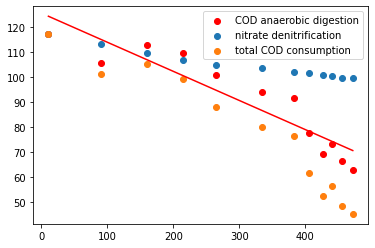

In [10]:
calculate_from_Denitrification_NO3(target="De_nitrate1")

实验过程中的COD/TN为9.520960480480483
硝酸盐去除COD：[112.3821872, 108.48114720000001, 105.50102720000001, 102.8154872, 100.1042072, 96.7379872, 94.35560720000001, 94.28124720000001, 94.16398720000001, 94.0267072, 93.5948472, 93.3345872]
厌氧消化去除COD[112.3821872, 107.42163759999998, 104.30941474999999, 98.44105920999999, 94.68455184, 89.95847515999999, 86.92848735999999, 80.59976233, 79.79394008, 72.70656299000001, 70.66456256000001, 68.02019040000002]
pearsonr为 (-0.972217659409458, 1.244165393112282e-07)
[-0.093486] 117.33134232880228
单位VSS的厌氧COD去除速率:0.190 mgCOD/gVSS/min


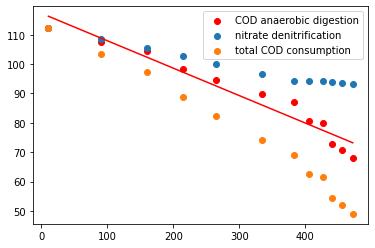

In [11]:
calculate_from_Denitrification_NO3(target="De_nitrate2")

实验过程中的COD/TN为9.915994453805109
硝酸盐去除COD：[128.7515125, 124.2498725, 120.1572125, 117.2457325, 115.1522125, 112.35799250000001, 110.83647250000001, 110.24445250000001, 109.6781725, 109.28349250000001, 108.70863250000001, 108.3825925]
厌氧消化去除COD[128.7515125, 122.5207828, 114.41644939999999, 99.83859761999999, 95.86439028999999, 90.11702251999998, 85.28773661999998, 82.50905999999998, 79.87068909999999, 78.39766022999999, 79.15097125999999, 78.49871999999999]
pearsonr为 (-0.9897610310826754, 8.711761674177955e-10)
[-0.11547954] 129.81360154132068
单位VSS的厌氧COD去除速率:0.225 mgCOD/gVSS/min


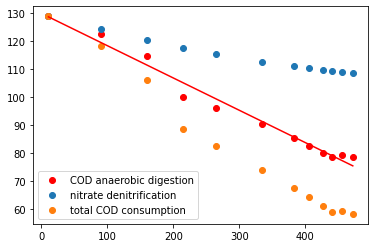

In [12]:
calculate_from_Denitrification_NO3(target="De_nitrate3")

In [13]:
anaerobic_rate

{'Denitrification_NO2': {'De_nitrite1': -0.21225065459975054,
  'De_nitrite2': -0.2776092581901453,
  'De_nitrite3': -0.2679447121813256},
 'Denitrification_NO3': {'De_nitrate1': -0.23162012569692242,
  'De_nitrate2': -0.19039918670845787,
  'De_nitrate3': -0.22466836006725502}}

In [20]:
def calculate_mean_rate():
    '''
    通过协程计算平均的厌氧反应速率
    :return:
    '''
    
    mean_rate=0
    count=0
    total=0
    while True:
        assay_rate=yield mean_rate
        if assay_rate!=None:
            
            total-=assay_rate
            count+=1
            mean_rate=total/count


In [21]:

#创建平均速率生成器
mean_rate_gens=calculate_mean_rate()
# 预激活生成器
next(mean_rate_gens)
for _,assays in anaerobic_rate.items():
    for _,value in assays.items():
        mean_COD_anaerobic_digestion_rate=mean_rate_gens.send(value)
#关闭生成器
mean_rate_gens.close()
mean_COD_anaerobic_digestion_rate

0.2340820472568057

In [22]:
# 将这个平均速率保存为一个json文件
import json
filename ='COD_anaerobic_digestion_rate.json'
with open(filename, 'w',encoding="utf-8") as file_obj:
    json.dump({
        "COD_anaerobic_digestion_rate":mean_COD_anaerobic_digestion_rate,
    }, file_obj,ensure_ascii=False)